In [1]:
import pandas as pd
import os
import cv2
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import ViT
import importlib

In [2]:
import torch_directml
dml = torch_directml.device()
dml

device(type='privateuseone', index=0)

In [3]:
data_path = "../data/archive/hasy-data-labels.csv"
base_path = "../data/archive/"

images = []
labels = []

df = pd.read_csv(data_path)

for i in df.index:
    img_path = os.path.join(base_path, str(df.loc[i, "path"]))

    if not os.path.exists(img_path):
        continue

    img = cv2.imread(img_path)

    if img is None:
        continue
    
    grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    images.append(grey_img)
    
    label = df.loc[i, "symbol_id"]
    labels.append(label)

In [4]:
images = torch.from_numpy(np.array(images)).unsqueeze(1).to(torch.float32)
labels = torch.from_numpy(np.array(labels)).to(torch.float32)
print(images.shape)
print(labels.shape)

torch.Size([167867, 1, 32, 32])
torch.Size([167867])


In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=0)
X_train = X_train.to(dml)
X_test = X_test.to(dml)

In [6]:
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse_output = False)

labels_int = label_encoder.fit_transform(labels)
onehot_encoder.fit(np.reshape(labels_int, (len(labels), 1)))

y_train_int = torch.FloatTensor(label_encoder.transform(y_train))
y_train_onehot = torch.FloatTensor(onehot_encoder.transform(np.reshape(y_train_int, (len(y_train_int), 1))))
y_test_int = torch.FloatTensor(label_encoder.transform(y_test))
y_test_onehot = torch.FloatTensor(onehot_encoder.transform(np.reshape(y_test_int, (len(y_test_int), 1))))

y_train_int = y_train_int.to(dml)
y_test_int = y_test_int.to(dml)

num_of_classes = len(label_encoder.classes_)
print(num_of_classes)

369


In [7]:
def get_accuracy(model, X, y, eval_size):
    outputs = model(X[0:eval_size])
    _, predicted = torch.max(outputs, 1)
    total_correct = (predicted == y[0:eval_size]).sum().item()
    total_samples = y[0:eval_size].shape[0]
    accuracy = 100 * total_correct / total_samples 
    return accuracy    

In [11]:
importlib.reload(ViT)

model_config = {
    "img_size": 32,
    "patch_size": 4,
    "in_channels": 1,
    "n_classes": 369,
    "emb_dim": 256,
    "depth": 3,
    "n_heads": 16,
    "mlp_ratio": 4,
    "qkv_bias": True,
    "p": 0,
    "attn_p": 0
}

model = ViT.ViT(**model_config).to(dml)

num_epochs = 30
batch_size = 1000
learning_rate = 0.001
eval_size = 1000

train_accuracies = []
test_accuracies = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    model.train()

    for i in range(0, len(X_train), batch_size):
    
        X_train_batch = X_train[i:(i + batch_size)].to(dml)
        y_train_onehot_batch = y_train_onehot[i:(i + batch_size)].to(dml) 

        # forward
        outputs = model(X_train_batch)
        loss = criterion(outputs, y_train_onehot_batch)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
          
        print(f"loss is {loss.item()} mini-batch {i / batch_size} of {int(len(X_train) / batch_size)} of epoch {epoch}")

    model.eval()
    
    test_accuracy = get_accuracy(model, X_test, y_test_int, eval_size)
    test_accuracies.append(test_accuracy)

    train_accuracy = get_accuracy(model, X_train, y_train_int, eval_size)
    train_accuracies.append(train_accuracy)

    print(f"epoch {epoch}: train_accuracy is {train_accuracy}, test_accuracy is {test_accuracy}")

loss is 6.063486099243164 mini-batch 0.0 of 117 of epoch 0
loss is 5.928659915924072 mini-batch 1.0 of 117 of epoch 0
loss is 5.792877197265625 mini-batch 2.0 of 117 of epoch 0
loss is 5.681196689605713 mini-batch 3.0 of 117 of epoch 0
loss is 5.5944647789001465 mini-batch 4.0 of 117 of epoch 0
loss is 5.492953300476074 mini-batch 5.0 of 117 of epoch 0
loss is 5.450942516326904 mini-batch 6.0 of 117 of epoch 0
loss is 5.41486930847168 mini-batch 7.0 of 117 of epoch 0
loss is 5.439789295196533 mini-batch 8.0 of 117 of epoch 0
loss is 5.394319534301758 mini-batch 9.0 of 117 of epoch 0
loss is 5.456593990325928 mini-batch 10.0 of 117 of epoch 0
loss is 5.4050798416137695 mini-batch 11.0 of 117 of epoch 0
loss is 5.436824321746826 mini-batch 12.0 of 117 of epoch 0
loss is 5.4112348556518555 mini-batch 13.0 of 117 of epoch 0
loss is 5.442893981933594 mini-batch 14.0 of 117 of epoch 0
loss is 5.480587005615234 mini-batch 15.0 of 117 of epoch 0
loss is 5.439467906951904 mini-batch 16.0 of 117

KeyboardInterrupt: 

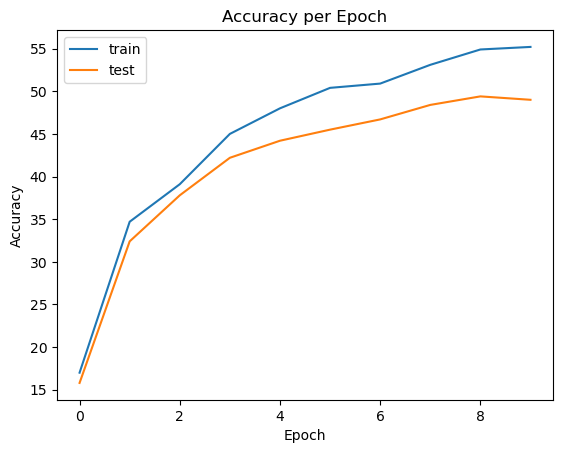

In [13]:
fig, ax = plt.subplots()
ax.plot(range(10), train_accuracies, label="train") 
ax.plot(range(10), test_accuracies, label="test")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy per Epoch')
ax.legend()
plt.show()